<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S7/CIFAR10_Assignment7_withAdvancedConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install the dependencies


In [153]:
!pip install torchsummary

### Import dependencies

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from torch.optim.lr_scheduler import StepLR

### Helper utilities

In [155]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def isCuda():
  return torch.cuda.is_available()

def randInt(min, max, size): 
  return torch.LongTensor(size).random_(min, max)

def getDevice(): 
  return torch.device("cuda" if isCuda() else "cpu")

def showImages(images, labels, cols=10): 
  figure = plt.figure(figsize=(15, 15))
  num_of_images = len(images)
  rows = np.ceil(num_of_images/float(cols))
  for index in range(0, num_of_images):
    plt.subplot(rows, cols, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze()) 
    plt.title(classes[labels[index].item()])

def unnormalize(t, mean, sig): 
  return t * sig + mean

cpu = torch.device("cpu")
device = getDevice()
print(f'\nDevice: {device}')

# Set seed 
seed =1 
torch.manual_seed(seed)
if isCuda():
  torch.cuda.manual_seed(seed)



Device: cuda


### Transformations for Train and Test

In [0]:
def train_transformations(): 
  return transforms.Compose([
                    transforms.RandomHorizontalFlip(),          
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
  
def test_transformations(): 
  return transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Load train and test data

In [157]:
def shape(loader, name): 
  d, l = iter(train_loader).next()
  print(f'Shape of a {name} batch: {d.shape}')

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if isCuda() else dict(shuffle=True, batch_size=64)

train_data = datasets.CIFAR10("../data", train=True, transform=train_transformations(), download=True)
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

test_data = datasets.CIFAR10("../data", train=False, transform=test_transformations(), download=True)
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

shape(train_loader, "train data")
shape(test_loader, "test data")

print(f'Number of train images: {len(train_data.data)}')
print(f'Number of test images: {len(test_data.data)}')

Files already downloaded and verified
Files already downloaded and verified
Shape of a train data batch: torch.Size([128, 3, 32, 32])
Shape of a test data batch: torch.Size([128, 3, 32, 32])
Number of train images: 50000
Number of test images: 10000


### View training/test data and their statistics


Random training images



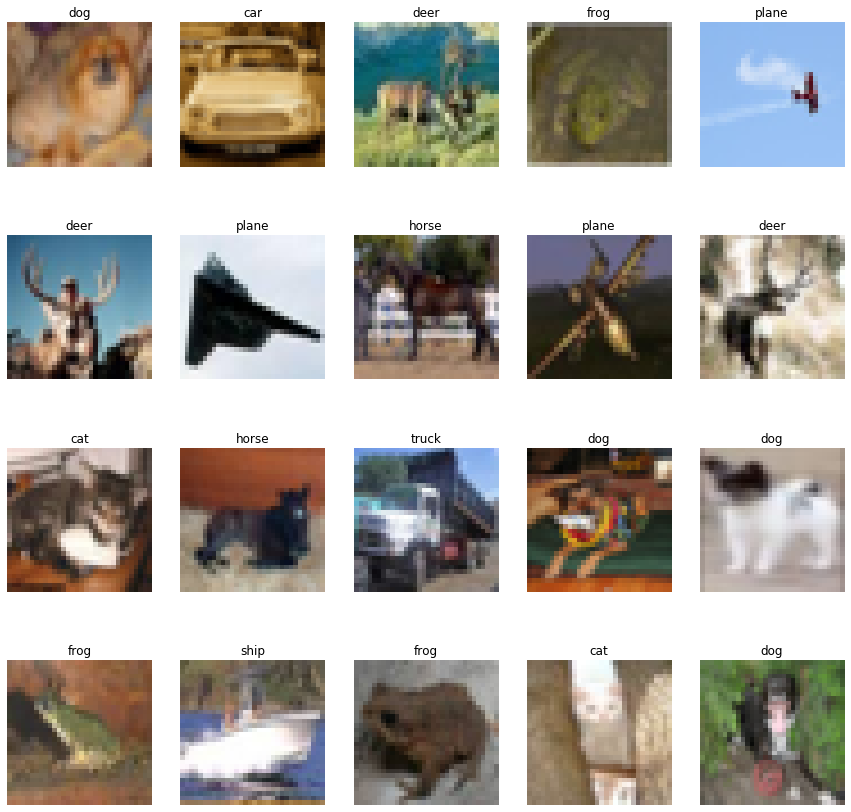

In [158]:
def showRandomImages(loader, count=20):
  d, l = iter(loader).next()
  randImages = randInt(0, len(d), count)
  t = unnormalize(d[randImages].permute(0, 2, 3, 1), 0.5, 0.5)
  showImages(t, l[randImages], cols=5)

print("Random training images\n")
showRandomImages(train_loader)

# print("Random test images\n")
# showRandomImages(test_loader)

### Network architecture

In [159]:
class Net(nn.Module): 

  def __init__(self): 
    super(Net, self).__init__()

    drop_out = 0.1

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False, dilation=2), # RF - 5
        nn.ReLU(), 
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False), # RF - 7
        nn.ReLU(), 
        nn.BatchNorm2d(32),
        nn.Dropout2d(drop_out),
    ) # Output - 30

    self.transition1 = nn.Sequential(
        nn.MaxPool2d(2, 2), ## RF - 8
    ) # Output - 15

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False), # RF - 12
        nn.ReLU(), 
        nn.BatchNorm2d(64),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False), # RF - 16
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout2d(drop_out),
    ) # Output - 11

    self.transition2 = nn.Sequential(
        nn.MaxPool2d(2, 2), ## RF - 18
    ) # Output - 5

    self.depthwiseSeparable = nn.Sequential(
        # Depthwise 
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, groups=64), # RF - 26
        # Pointwise
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1), bias=False), # RF - 26
        nn.ReLU(), 
        nn.BatchNorm2d(128),
        nn.Dropout2d(drop_out)
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), # RF - 34
    ) # Output - 5

    self.gap1 = nn.AdaptiveAvgPool2d(1) # RF - 50
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), bias=False) # RF - 50

  def forward(self, x): 

    x = self.transition1(self.conv1(x))
    x = self.transition2(self.conv2(x))
    x = self.conv3(self.depthwiseSeparable(x))
    x = self.conv4(self.gap1(x))
    x = x.view(-1, 10)
    return F.log_softmax(x)

  def summarize(self, input): 
    summary(self, input_size=input)

Net().to(getDevice()).summarize((3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
            Conv2d-4           [-1, 32, 28, 28]           9,216
              ReLU-5           [-1, 32, 28, 28]               0
       BatchNorm2d-6           [-1, 32, 28, 28]              64
         Dropout2d-7           [-1, 32, 28, 28]               0
         MaxPool2d-8           [-1, 32, 14, 14]               0
            Conv2d-9           [-1, 64, 12, 12]          18,432
             ReLU-10           [-1, 64, 12, 12]               0
      BatchNorm2d-11           [-1, 64, 12, 12]             128
        Dropout2d-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 64, 10, 10]          36,864
             ReLU-14           [-1, 64,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### Utilities to compute metrics

In [0]:
def compute_accuracy(prediction, target): 
  return 100 * prediction.eq(target.view_as(prediction)).sum().item() / float(len(prediction))

def compute_miss(data, prediction, target): 
  corrects = prediction.eq(target.view_as(prediction))
  accuracy = corrects.sum().item() / len(prediction)
  miss_indices = ~corrects
  miss_data = data[miss_indices]  
  miss_predictions = prediction[miss_indices]
  miss_targets = target[miss_indices]
  print(confusion_matrix(target.to(cpu), prediction.to(cpu)))
  return (miss_data, miss_predictions, miss_targets)

### Code to train the model

In [0]:
factor = 0.01

def compute_L1(model): 
  allWeights = torch.cat([x.view(-1) for x in model.parameters()])
  loss = torch.norm(allWeights, 1)
  return loss

def compute_L2(model): 
  allWeights = torch.cat([x.view(-1) for x in model.parameters()])
  loss = torch.norm(allWeights, 2)
  return loss

def train_one_batch(model, data, target, optimizer): 
  optimizer.zero_grad()
  output = model(data)
  loss = F.nll_loss(output, target) + factor * compute_L2(model)
  loss.backward()
  optimizer.step()
  return (loss, output.argmax(dim=1))

def train_one_epoch(model, train_loader, optimizer, device=getDevice()): 
  model.train()
  pbar = tqdm(train_loader, ncols=1000) 
  wholePred = []
  wholeData = []
  wholeTarget = []
  totalLoss = 0
  for idx, (data, target) in enumerate(pbar): 
    data, target = data.to(device), target.to(device)
    (loss, prediction) = train_one_batch(model, data, target, optimizer)
    accuracy = compute_accuracy(prediction, target)
    wholePred.append(prediction)
    wholeData.append(data)
    wholeTarget.append(target)
    totalLoss += loss
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred), totalLoss/len(train_loader.dataset))

### Code to test the model

In [0]:
def test_one_batch(model, data, target): 
  output = model(data)
  loss = F.nll_loss(output, target)
  return (loss, output.argmax(dim=1))
  
def test(model, test_loader, device=getDevice()): 
  model.eval()
  pbar = tqdm(test_loader, ncols=1000)
  wholePred = []
  wholeData = []
  wholeTarget = []
  totalLoss = 0
  with torch.no_grad(): 
    for idx, (data, target) in enumerate(pbar): 
      data, target = data.to(device), target.to(device)
      (loss, prediction) = test_one_batch(model, data, target)
      totalLoss += loss
      accuracy = compute_accuracy(prediction, target)
      wholePred.append(prediction)
      wholeData.append(data)
      wholeTarget.append(target)
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred), totalLoss/len(test_loader.dataset))

### Build the model by training and testing. 

In [163]:
def build(model, train_loader, optimizer, epoch, scheduler):
  train_accs = []
  train_losses = []
  test_accs = [] 
  test_losses = []
  for e in range(0, epoch): 
    print(f'\n\nEpoch: {e + 1}')
    (train_data, train_target, train_prediction, avgTrainLoss) = train_one_epoch(model, train_loader, optimizer)
    trainAcc = compute_accuracy(train_prediction, train_target)
    train_accs.append(trainAcc)
    train_losses.append(avgTrainLoss)
    print(f'Train Accuracy: {trainAcc}%, Train Loss: {avgTrainLoss}')
    (test_data, test_target, test_prediction, avgTestLoss) = test(net, test_loader)
    testAcc = compute_accuracy(test_prediction, test_target)
    test_accs.append(testAcc)
    test_losses.append(avgTestLoss)
    print(f'Test Accuracy: {testAcc}%, Test Loss: {avgTestLoss}')
    scheduler.step()
  return(train_accs, train_losses, test_accs, test_losses)

net = Net().to(getDevice())
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
(train_accs, train_losses, test_accs, test_losses) = build(net, train_loader, optimizer, 40, optimizer)



Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Accuracy: 46.408%, Train Loss: 0.013208243064582348


Test Accuracy: 58.65%, Test Loss: 0.0089546674862504


Epoch: 2


Train Accuracy: 60.0%, Train Loss: 0.010531353764235973


Test Accuracy: 65.29%, Test Loss: 0.007596242241561413


Epoch: 3


Train Accuracy: 65.044%, Train Loss: 0.0094714080914855


Test Accuracy: 71.08%, Test Loss: 0.006606088951230049


Epoch: 4


Train Accuracy: 68.41%, Train Loss: 0.008792425505816936


Test Accuracy: 72.42%, Test Loss: 0.006219256203621626


Epoch: 5


Train Accuracy: 70.556%, Train Loss: 0.008362282067537308


Test Accuracy: 74.76%, Test Loss: 0.005708072334527969


Epoch: 6


Train Accuracy: 72.078%, Train Loss: 0.008057396858930588


Test Accuracy: 75.56%, Test Loss: 0.005585763603448868


Epoch: 7


Train Accuracy: 73.274%, Train Loss: 0.007760659791529179


Test Accuracy: 75.99%, Test Loss: 0.005365710239857435


Epoch: 8


Train Accuracy: 74.292%, Train Loss: 0.007576870732009411


Test Accuracy: 77.33%, Test Loss: 0.005162546876817942


Epoch: 9


Train Accuracy: 75.27%, Train Loss: 0.007372321095317602


Test Accuracy: 78.15%, Test Loss: 0.0051290192641317844


Epoch: 10


Train Accuracy: 75.86%, Train Loss: 0.007232717238366604


Test Accuracy: 78.13%, Test Loss: 0.004998848307877779


Epoch: 11


Train Accuracy: 76.792%, Train Loss: 0.007105810567736626


Test Accuracy: 78.89%, Test Loss: 0.004897113889455795


Epoch: 12


Train Accuracy: 77.076%, Train Loss: 0.006981890182942152


Test Accuracy: 79.14%, Test Loss: 0.004766007885336876


Epoch: 13


Train Accuracy: 77.502%, Train Loss: 0.006890180520713329


Test Accuracy: 79.68%, Test Loss: 0.004656956996768713


Epoch: 14


Train Accuracy: 77.77%, Train Loss: 0.006816912442445755


Test Accuracy: 79.67%, Test Loss: 0.0047140419483184814


Epoch: 15


Train Accuracy: 78.174%, Train Loss: 0.00675594387575984


Test Accuracy: 80.04%, Test Loss: 0.0045399134978652


Epoch: 16


Train Accuracy: 78.236%, Train Loss: 0.006695110350847244


Test Accuracy: 80.12%, Test Loss: 0.004554583225399256


Epoch: 17


Train Accuracy: 79.136%, Train Loss: 0.006590807344764471


Test Accuracy: 80.79%, Test Loss: 0.00446534575894475


Epoch: 18


Train Accuracy: 78.998%, Train Loss: 0.006547648925334215


Test Accuracy: 79.88%, Test Loss: 0.004546774551272392


Epoch: 19


Train Accuracy: 79.08%, Train Loss: 0.006509924307465553


Test Accuracy: 81.23%, Test Loss: 0.004374217242002487


Epoch: 20


Train Accuracy: 79.51%, Train Loss: 0.0064750052988529205


Test Accuracy: 80.49%, Test Loss: 0.004439693875610828


Epoch: 21


Train Accuracy: 79.794%, Train Loss: 0.006398661993443966


Test Accuracy: 80.79%, Test Loss: 0.0043937694281339645


Epoch: 22


Train Accuracy: 79.922%, Train Loss: 0.006389131769537926


Test Accuracy: 81.23%, Test Loss: 0.004411793313920498


Epoch: 23


Train Accuracy: 80.12%, Train Loss: 0.006333968136459589


Test Accuracy: 81.17%, Test Loss: 0.004312287550419569


Epoch: 24


Train Accuracy: 80.262%, Train Loss: 0.006296543870121241


Test Accuracy: 81.24%, Test Loss: 0.0043923514895141125


Epoch: 25


Train Accuracy: 80.472%, Train Loss: 0.00625485647469759


Test Accuracy: 80.87%, Test Loss: 0.004438766743987799


Epoch: 26


Train Accuracy: 80.546%, Train Loss: 0.006229717284440994


Test Accuracy: 81.81%, Test Loss: 0.00421807449311018


Epoch: 27


Train Accuracy: 80.74%, Train Loss: 0.006205389276146889


Test Accuracy: 82.39%, Test Loss: 0.004139960277825594


Epoch: 28


Train Accuracy: 80.918%, Train Loss: 0.006173691712319851


Test Accuracy: 81.86%, Test Loss: 0.004219005350023508


Epoch: 29


Train Accuracy: 81.17%, Train Loss: 0.006115538068115711


Test Accuracy: 80.64%, Test Loss: 0.004389966372400522


Epoch: 30


Train Accuracy: 81.362%, Train Loss: 0.006095308810472488


Test Accuracy: 82.05%, Test Loss: 0.004074797499924898


Epoch: 31


Train Accuracy: 81.462%, Train Loss: 0.006084964610636234


Test Accuracy: 81.71%, Test Loss: 0.004175981972366571


Epoch: 32


Train Accuracy: 81.378%, Train Loss: 0.006042660214006901


Test Accuracy: 82.15%, Test Loss: 0.004120257683098316


Epoch: 33


Train Accuracy: 81.726%, Train Loss: 0.006035026628524065


Test Accuracy: 82.47%, Test Loss: 0.0040816632099449635


Epoch: 34


Train Accuracy: 81.6%, Train Loss: 0.006022260989993811


Test Accuracy: 82.36%, Test Loss: 0.004107269924134016


Epoch: 35


Train Accuracy: 81.642%, Train Loss: 0.006003997754305601


Test Accuracy: 81.72%, Test Loss: 0.00419259537011385


Epoch: 36


Train Accuracy: 81.902%, Train Loss: 0.00596263213083148


Test Accuracy: 82.64%, Test Loss: 0.004088805057108402


Epoch: 37


Train Accuracy: 81.902%, Train Loss: 0.005960640497505665


Test Accuracy: 82.73%, Test Loss: 0.004045397508889437


Epoch: 38


Train Accuracy: 82.138%, Train Loss: 0.0059175011701881886


Test Accuracy: 82.36%, Test Loss: 0.004103675018996


Epoch: 39


Train Accuracy: 82.118%, Train Loss: 0.005930094514042139


Test Accuracy: 82.02%, Test Loss: 0.004160861950367689


Epoch: 40


Train Accuracy: 82.394%, Train Loss: 0.005876698065549135


Test Accuracy: 81.85%, Test Loss: 0.004172846674919128


Text(0.5, 1.0, 'Test Loss')

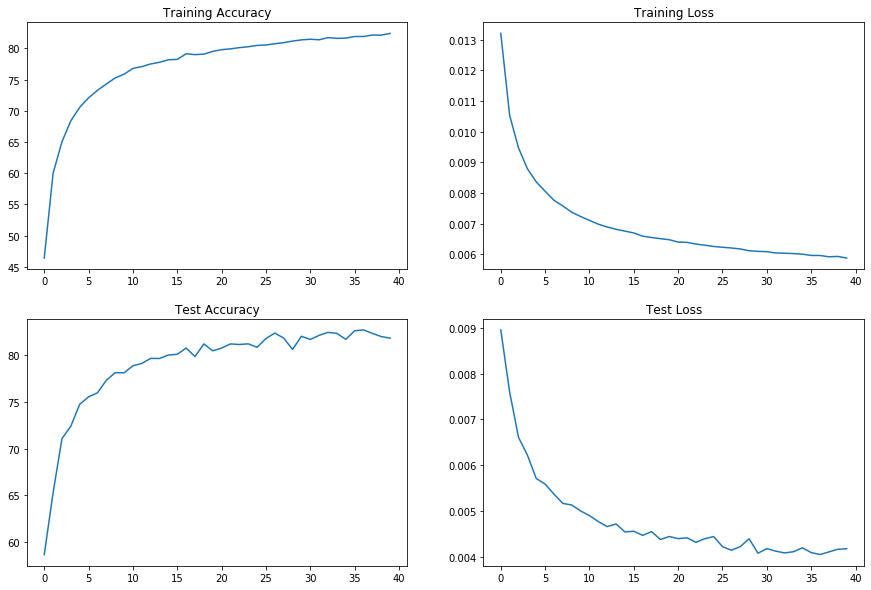

In [164]:
fig, axs = plt.subplots(2,2,figsize=(15, 10))
axs[0, 0].plot(train_accs)
axs[0, 0].set_title("Training Accuracy")
axs[0, 1].plot(train_losses)
axs[0, 1].set_title("Training Loss")
axs[1, 0].plot(test_accs)
axs[1, 0].set_title("Test Accuracy")
axs[1, 1].plot(test_losses)
axs[1, 1].set_title("Test Loss")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[[783  11  36  13  11   1   5  10  99  31]
 [ 11 887   3   4   3   3   7   0  36  46]
 [ 47   2 718  31  63  54  51  15  15   4]
 [ 13   1  50 628  52 150  55  18  16  17]
 [ 10   0  35  27 852  15  26  23  11   1]
 [  9   2  28 100  37 779  11  22   7   5]
 [  5   0  29  31  35  16 869   4   8   3]
 [  7   0  21  17  53  56   4 834   2   6]
 [ 19   9   3   5   0   2   4   2 944  12]
 [  9  42   5   2   3   4   5   2  35 893]]
torch.Size([1813, 3, 32, 32])


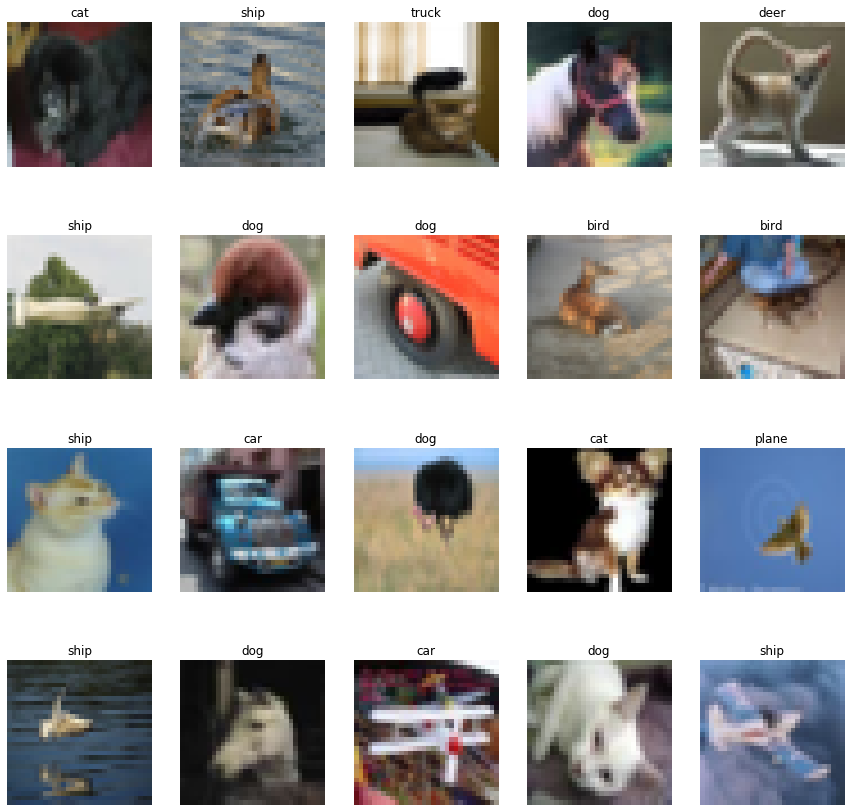

In [165]:
(test_data, test_target, test_prediction, avgTestLoss) = test(net, test_loader)
(miss_data, miss_predictions, miss_targets) = compute_miss(test_data, test_prediction, test_target)

randImages = randInt(0, len(miss_data), 20)
print(miss_data.shape)
showImages(unnormalize(miss_data[randImages].permute(0, 2, 3, 1).to(cpu), 0.5, 0.5), miss_predictions[randImages].to(cpu), cols=5)